In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd # For potential audio playback in notebooks
import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
from scipy.spatial.distance import cdist # For distance matrix calculations

In [2]:
# Define global parameters for audio processing
SR = 22050          # Sample rate
DURATION = 1        # Duration of audio segment to process (in seconds)
N_MFCC = 20        # Number of MFCCs to extract
N_MELS = 256        # Number of Mel bands to generate (used by MFCC internally)
HOP_LENGTH_MFCC = 512 # Hop length for MFCC calculation (influences number of frames)

expected_frames_mfcc = int(np.ceil(DURATION * SR / HOP_LENGTH_MFCC))
FIXED_SHAPE_MFCC = (N_MFCC, expected_frames_mfcc)

In [3]:
def audio_to_mfcc(audio_path):
    try:
        # Load audio with fixed duration
        y, sr = librosa.load(audio_path, sr=SR, duration=DURATION)

        # Pad audio if it's shorter than the desired duration
        if len(y) < SR * DURATION:
            y = np.pad(y, (0, max(0, int(SR * DURATION) - len(y))))

        # Trim leading and trailing silence
        y_trimmed, _ = librosa.effects.trim(y, top_db=40)

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=N_MFCC,
                                    n_mels=N_MELS, hop_length=HOP_LENGTH_MFCC)

        # Ensure consistent shape by truncating or padding time frames (columns)
        if mfcc.shape[1] > FIXED_SHAPE_MFCC[1]:
            mfcc = mfcc[:, :FIXED_SHAPE_MFCC[1]] # Truncate columns
        elif mfcc.shape[1] < FIXED_SHAPE_MFCC[1]:
            mfcc = np.pad(mfcc, ((0,0), (0,FIXED_SHAPE_MFCC[1]-mfcc.shape[1])), mode='constant') # Pad columns

        # Sanity check for the number of MFCC coefficients (rows)
        if mfcc.shape[0] != FIXED_SHAPE_MFCC[0]:
            print(f"Warning: MFCC coefficient mismatch for {audio_path}. Expected {FIXED_SHAPE_MFCC[0]}, got {mfcc.shape[0]}.")
            # This should generally not happen if n_mfcc is fixed, but robust check.
            if mfcc.shape[0] < FIXED_SHAPE_MFCC[0]:
                mfcc = np.pad(mfcc, ((0, FIXED_SHAPE_MFCC[0] - mfcc.shape[0]), (0, 0)), mode='constant')
            else:
                mfcc = mfcc[:FIXED_SHAPE_MFCC[0], :]

        return mfcc.flatten() # Flatten the 2D MFCC array into a 1D feature vector
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

In [4]:
# Assuming your dataset path is 'mswc_microset/mswc_microset/en/clips'
wavs = list(Path("mswc_microset/mswc_microset/en/clips").rglob("*.opus"))
print(f"Found {len(wavs)} files")

# Limit the number of samples per keyword to manage computational load
keyword_dict = defaultdict(list)
MAX_SAMPLES_PER_KEYWORD = 50 # Keep this consistent for comparison
for wav in wavs:
    label = wav.parts[-2] # The parent directory name is the label (e.g., 'one', 'two')
    if len(keyword_dict[label]) < MAX_SAMPLES_PER_KEYWORD:
        keyword_dict[label].append(wav)

# Extract MFCC features for all selected audio files
mfcc_features = []
valid_labels = []
print("Processing audio files for MFCC extraction...")
for label, paths in keyword_dict.items():
    for path in paths:
        mfcc_vec = audio_to_mfcc(str(path))
        if mfcc_vec is not None:
            mfcc_features.append(mfcc_vec)
            valid_labels.append(label)

# Stack the list of MFCC feature vectors into a single NumPy array
mfccs_array = np.stack(mfcc_features)
print(f"Finished MFCC extraction. Final array shape: {mfccs_array.shape}")

Found 96099 files
Processing audio files for MFCC extraction...
Finished MFCC extraction. Final array shape: (1482, 880)


C:\Users\tyree\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tyree\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (1482, 2)


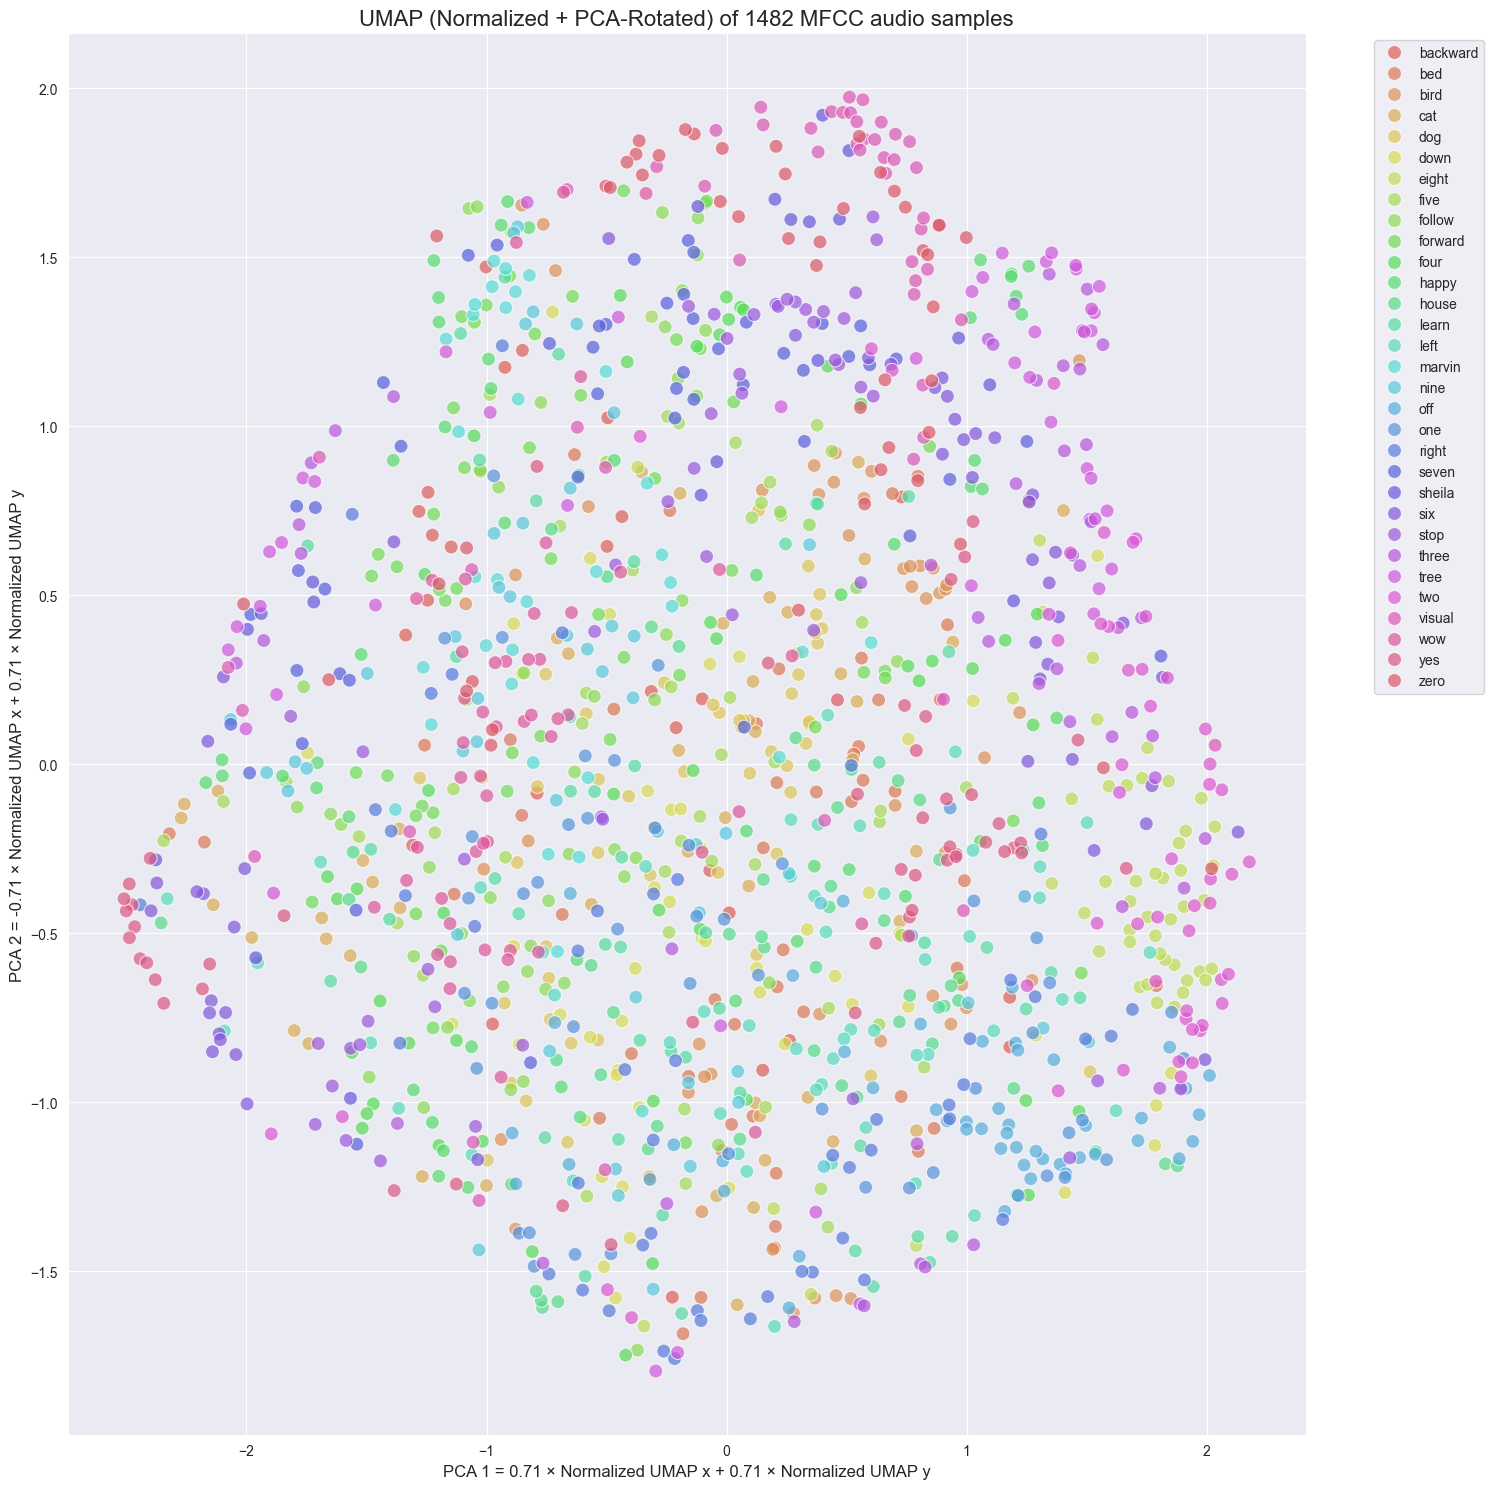

In [5]:
# Standardize the MFCC features before UMAP
scaler = StandardScaler()
scaled_mfccs = scaler.fit_transform(mfccs_array)

# Apply UMAP for dimensionality reduction
# random_state ensures reproducibility of the embedding
embedding = umap.UMAP(n_components=2, random_state=42).fit_transform(scaled_mfccs)
print(f"UMAP embedding shape: {embedding.shape}")

# Normalize the UMAP embedding before PCA
scaler_umap = StandardScaler()
normalized_embedding = scaler_umap.fit_transform(embedding)

# Apply PCA to rotate the normalized UMAP embedding
pca = PCA(n_components=2)
rotated_embedding = pca.fit_transform(normalized_embedding)

# Get PCA component coefficients for custom axis labels
pc1 = pca.components_[0]
pc2 = pca.components_[1]

# Format axis labels to indicate the transformation
x_label = f'PCA 1 = {pc1[0]:.2f} × Normalized UMAP x + {pc1[1]:.2f} × Normalized UMAP y'
y_label = f'PCA 2 = {pc2[0]:.2f} × Normalized UMAP x + {pc2[1]:.2f} × Normalized UMAP y'

# Create DataFrame for plotting
rotated_df = pd.DataFrame({
    'x': rotated_embedding[:, 0],
    'y': rotated_embedding[:, 1],
    'keyword': valid_labels
})

# Plot the UMAP embedding with PCA rotation
plt.figure(figsize=(15, 15))
sns.scatterplot(
    x='x', y='y',
    hue='keyword',
    data=rotated_df,
    palette=sns.color_palette('hls', len(set(valid_labels))),
    s=100,
    alpha=0.7
)
plt.xlabel(x_label, fontsize=12)
plt.ylabel(y_label, fontsize=12)
plt.title(f"English Subset of Multilingual Spoken Word Microset - MFCC UMAP (Normalized + PCA-Rotated) of {len(valid_labels)} Audio Samples", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

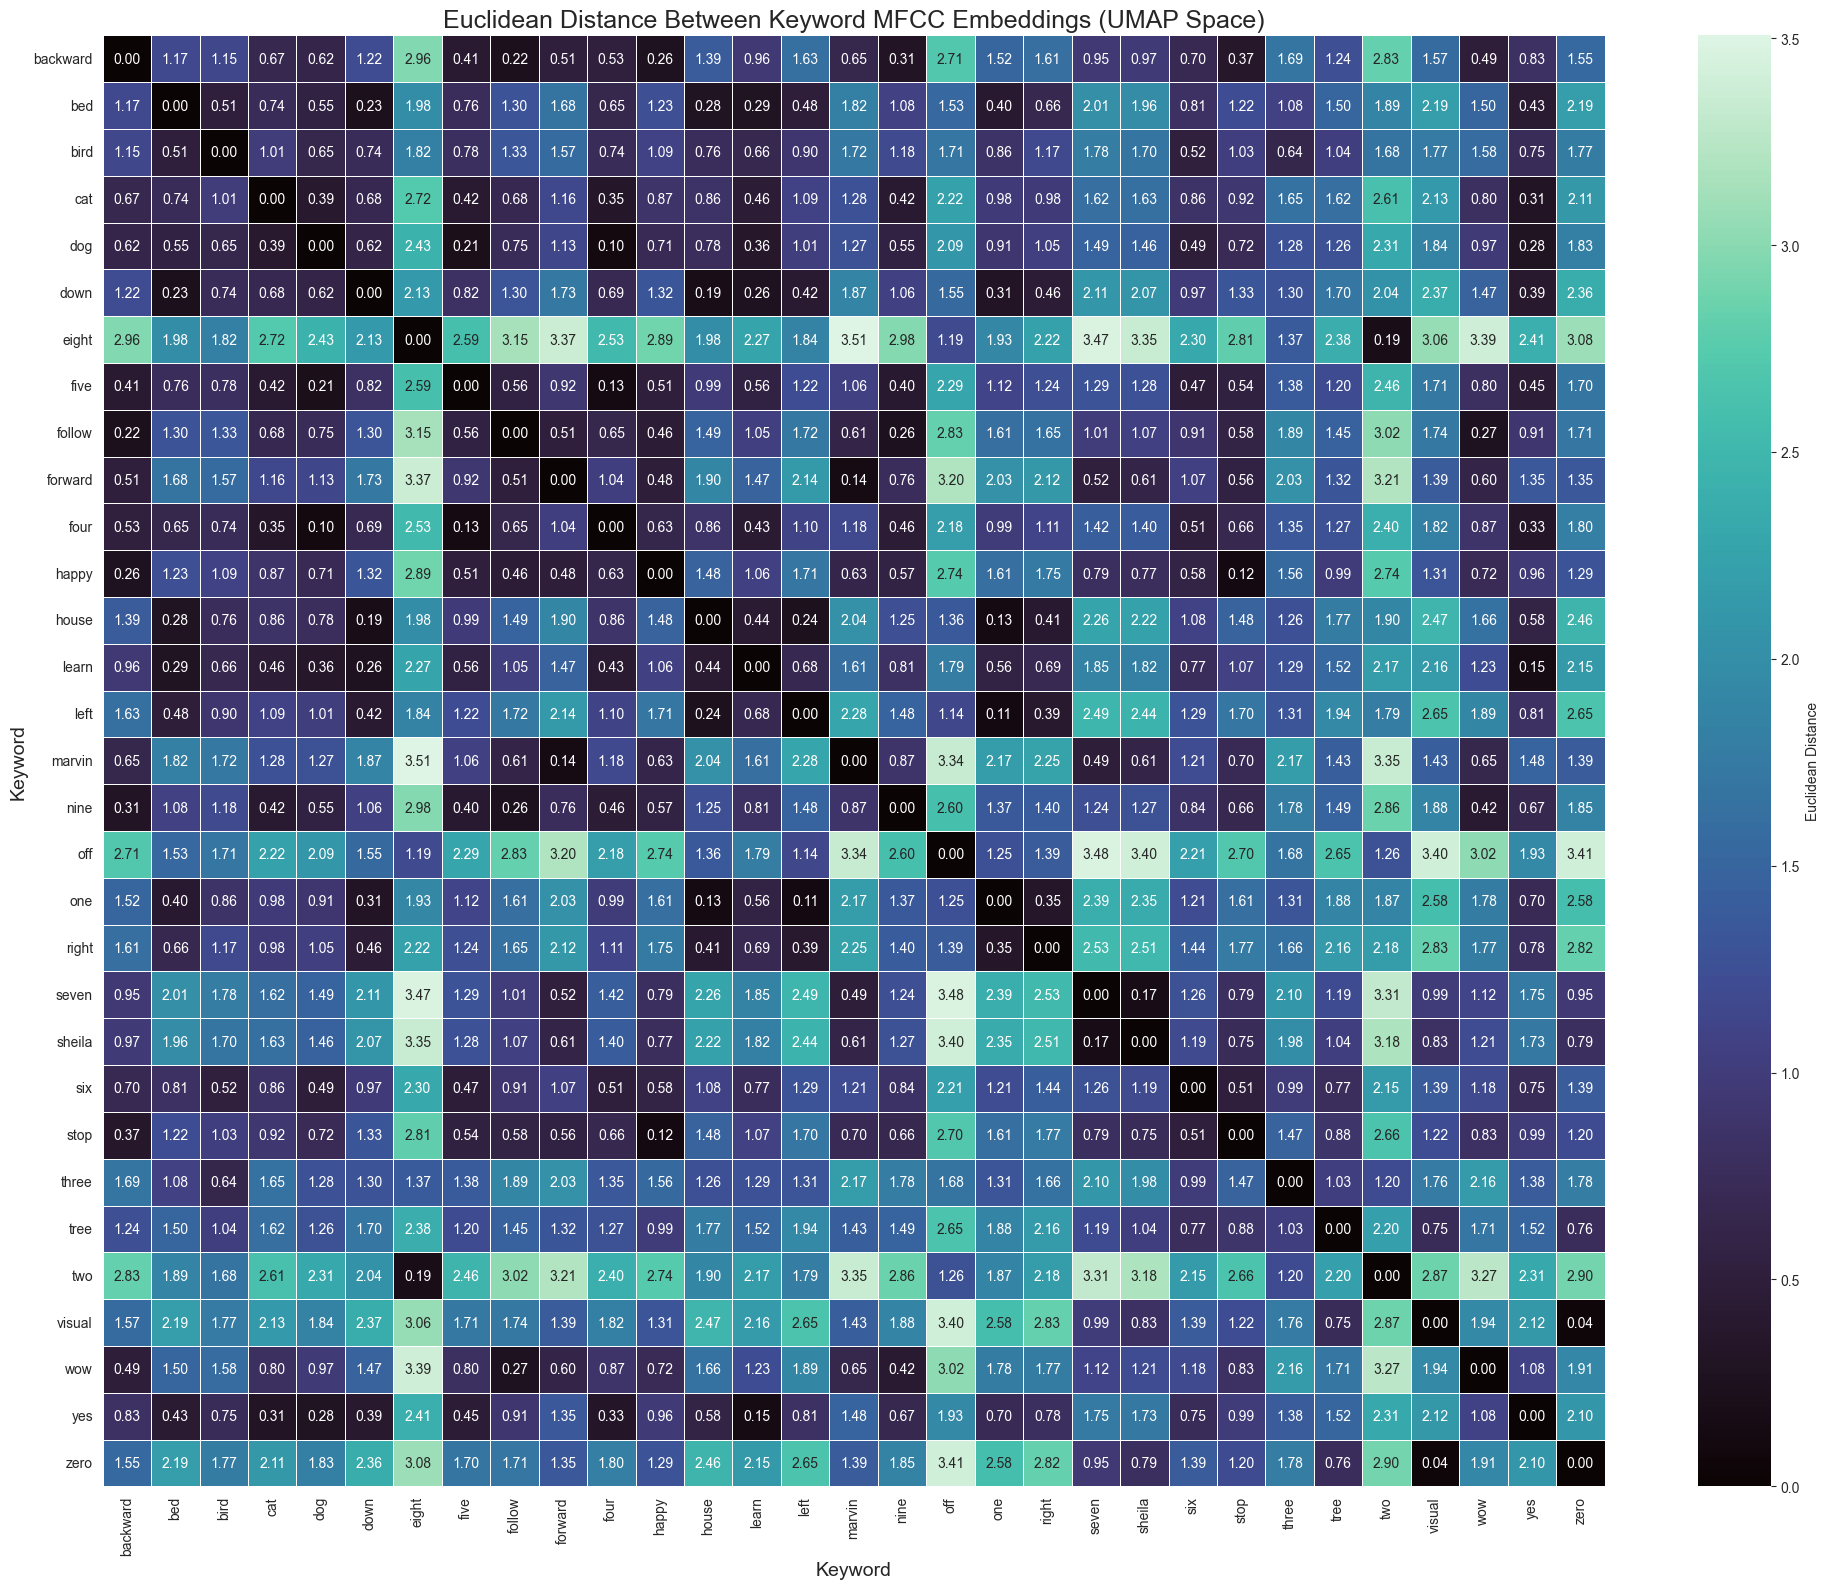

In [6]:
# Calculate mean embeddings for each keyword
unique_labels = sorted(list(set(valid_labels)))
label_to_vectors = {label: [] for label in unique_labels}
for label, vec in zip(valid_labels, embedding): # Use the original UMAP embedding for means
    label_to_vectors[label].append(vec)

label_means = {label: np.mean(vectors, axis=0) for label, vectors in label_to_vectors.items()}

# Prepare the mean vectors for distance calculation
mean_matrix = np.array([label_means[label] for label in unique_labels])
distance_matrix = cdist(mean_matrix, mean_matrix, metric='euclidean')

# Create heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(
    distance_matrix,
    xticklabels=unique_labels,
    yticklabels=unique_labels,
    cmap="mako",
    annot=True,
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Euclidean Distance'}
)
plt.title("Euclidean Distance Between Keyword MFCC Embeddings (UMAP Space)", fontsize=18)
plt.xlabel("Keyword", fontsize=14)
plt.ylabel("Keyword", fontsize=14)
plt.tight_layout()
plt.show()

Silhouette Score for KMeans on 'eight' vs 'seven': 0.6172


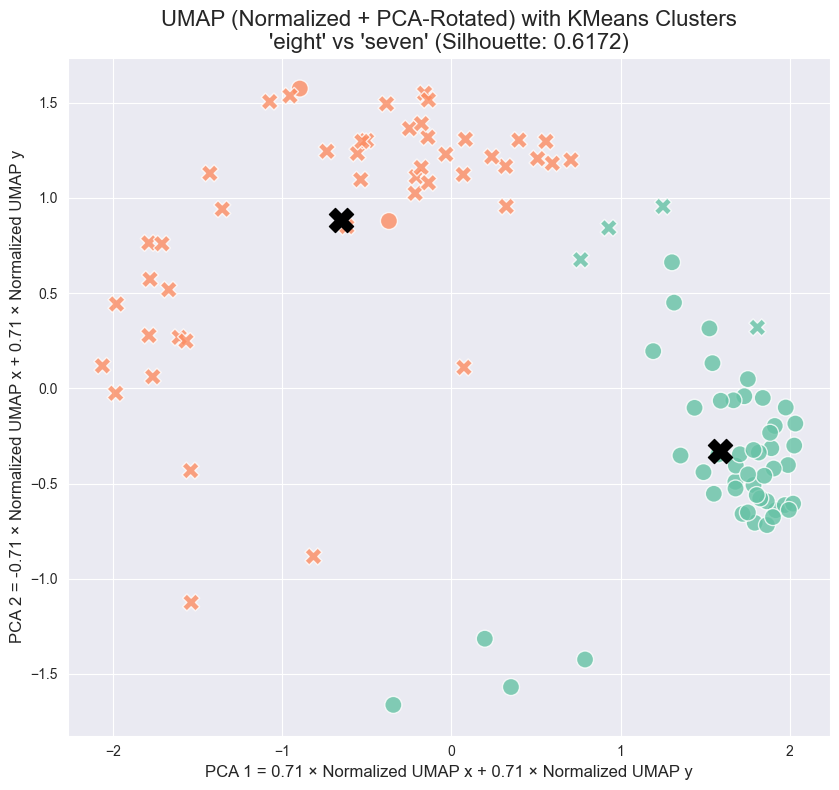

In [7]:
target_keywords = ['eight', 'seven'] # Example: Replace with your actual keywords!

# Filter dataframe for target keywords
subset_df = rotated_df[rotated_df['keyword'].isin(target_keywords)].copy()

# Prepare data for KMeans (only x, y coordinates from the rotated embedding)
X = subset_df[['x', 'y']].values

# Run KMeans with 2 clusters (since we have 2 words)
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
subset_df['cluster'] = kmeans.fit_predict(X)
labels = kmeans.labels_

# Calculate Silhouette Score for clustering quality
sil_score = silhouette_score(X, labels)
print(f"Silhouette Score for KMeans on '{target_keywords[0]}' vs '{target_keywords[1]}': {sil_score:.4f}")

# Map cluster IDs back to the most common actual keyword within each cluster
cluster_to_keyword = {}
for cluster_id in subset_df['cluster'].unique():
    keywords_in_cluster = subset_df[subset_df['cluster'] == cluster_id]['keyword']
    most_common_keyword = Counter(keywords_in_cluster).most_common(1)[0][0]
    cluster_to_keyword[cluster_id] = most_common_keyword

# Add predicted keyword column based on cluster assignment
subset_df['predicted_keyword'] = subset_df['cluster'].map(cluster_to_keyword)

# Plot the results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='x', y='y',
    hue='predicted_keyword', # Color by the KMeans-assigned (predicted) keyword
    style='keyword',         # Use different markers for the true keyword
    data=subset_df,
    palette='Set2',
    s=150,
    alpha=0.8,
    legend='full'
)

# Plot cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, marker='X', label='Cluster Centers', zorder=5)

plt.title(f"UMAP (Normalized + PCA-Rotated) with KMeans Clusters\n'{target_keywords[0]}' vs '{target_keywords[1]}' (Silhouette: {sil_score:.4f})", fontsize=16)
plt.xlabel(x_label, fontsize=12)
plt.ylabel(y_label, fontsize=12)

# Custom legend setup for clarity
handles, labels = plt.gca().get_legend_handles_labels()

hue_labels = [l for l in labels if l in target_keywords]
hue_handles = [h for h, l in zip(handles, labels) if l in target_keywords]

style_labels = [l for l in labels if l not in target_keywords and l != 'Cluster Centers']
style_handles = [h for h, l in zip(handles, labels) if l not in target_keywords and l != 'Cluster Centers']

center_handle = [h for h, l in zip(handles, labels) if l == 'Cluster Centers'][0]
center_label = 'Cluster Centers'

legend1 = plt.legend(hue_handles, hue_labels, title="Predicted Keyword", loc='upper left', bbox_to_anchor=(1.05, 1))
plt.gca().add_artist(legend1)

legend2 = plt.legend(style_handles, style_labels, title="True Keyword", loc='upper left', bbox_to_anchor=(1.05, 0.75))
plt.gca().add_artist(legend2)

legend3 = plt.legend([center_handle], [center_label], loc='upper left', bbox_to_anchor=(1.05, 0.6))
plt.gca().add_artist(legend3)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [8]:
results = []

# Loop over all unique pairs of keywords
for i in range(len(unique_labels)):
    for j in range(i + 1, len(unique_labels)):
        k1, k2 = unique_labels[i], unique_labels[j]

        # Filter for these two keywords
        subset_df = rotated_df[rotated_df['keyword'].isin([k1, k2])].copy()
        X = subset_df[['x', 'y']].values

        # Skip if not enough samples
        if len(X) < 4:
            continue

        # KMeans
        kmeans = KMeans(n_clusters=2, random_state=42)
        labels = kmeans.fit_predict(X)

        # Silhouette Score
        try:
            sil_score = silhouette_score(X, labels)
        except ValueError:
            sil_score = np.nan

        # Euclidean distance between cluster means in original UMAP space
        vec1 = np.mean([vec for lbl, vec in zip(valid_labels, embedding) if lbl == k1], axis=0)
        vec2 = np.mean([vec for lbl, vec in zip(valid_labels, embedding) if lbl == k2], axis=0)
        dist = np.linalg.norm(vec1 - vec2)

        results.append({
            'keyword_1': k1,
            'keyword_2': k2,
            'silhouette_score': sil_score,
            'euclidean_distance': dist
        })

# Create DataFrame
results_df = pd.DataFrame(results)

# Drop NaNs
results_df = results_df.dropna()

In [9]:
results_df

,keyword_1,keyword_2,silhouette_score,euclidean_distance
0,backward,bed,0.429732,1.174743
1,backward,bird,0.408562,1.145626
2,backward,cat,0.410569,0.666300
3,backward,dog,0.371205,0.620230
4,backward,down,0.391064,1.217487
...,...,...,...,...
460,visual,yes,0.575495,2.116659
461,visual,zero,0.598848,0.043005
462,wow,yes,0.545151,1.082873
463,wow,zero,0.565124,1.909730


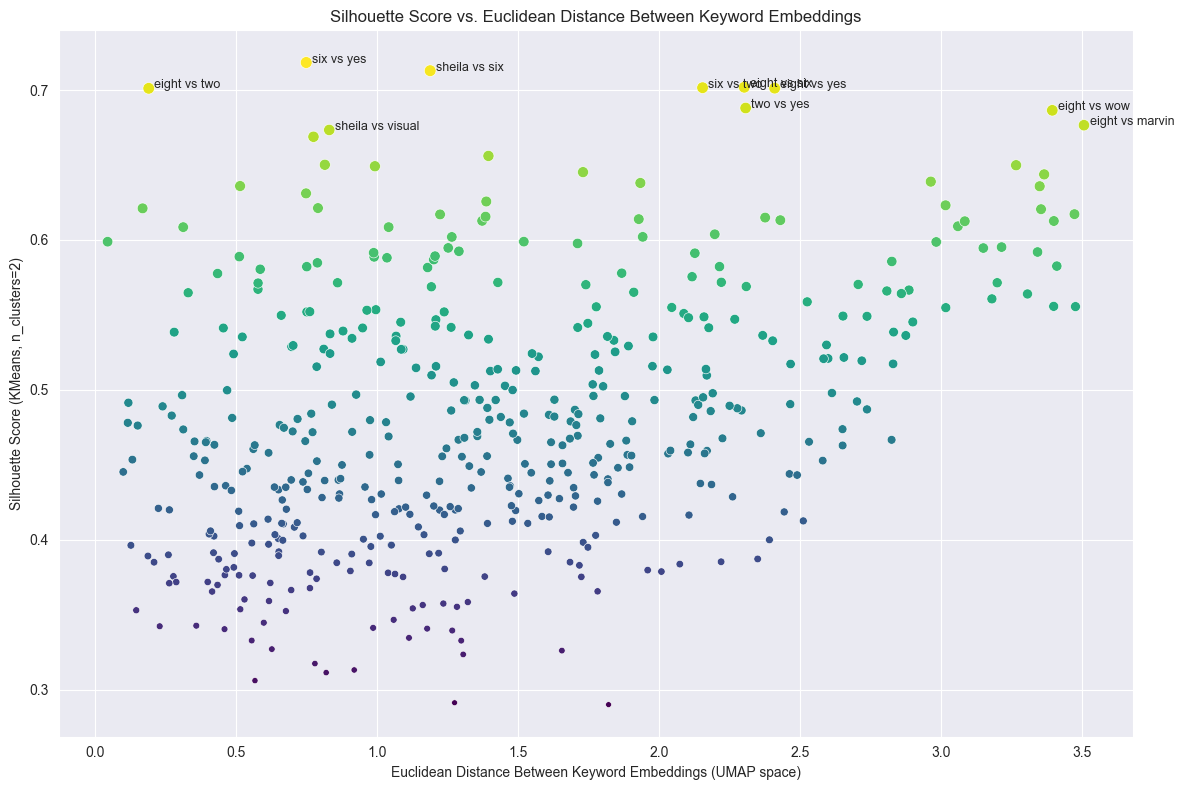

In [10]:
# Scatter plot of silhouette score vs. Euclidean distance
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='euclidean_distance',
    y='silhouette_score',
    hue='silhouette_score',
    size='silhouette_score',
    data=results_df,
    palette='viridis',
    legend=False
)

for _, row in results_df.nlargest(10, 'silhouette_score').iterrows():
    plt.text(row['euclidean_distance'] + 0.02, row['silhouette_score'],
             f"{row['keyword_1']} vs {row['keyword_2']}", fontsize=9)

plt.title("Silhouette Score vs. Euclidean Distance Between Keyword Embeddings")
plt.xlabel("Euclidean Distance Between Keyword Embeddings (UMAP space)")
plt.ylabel("Silhouette Score (KMeans, n_clusters=2)")
plt.tight_layout()
plt.show()

Pearson correlation (embedding distance vs silhouette): r = 0.419, p = 3.482e-21


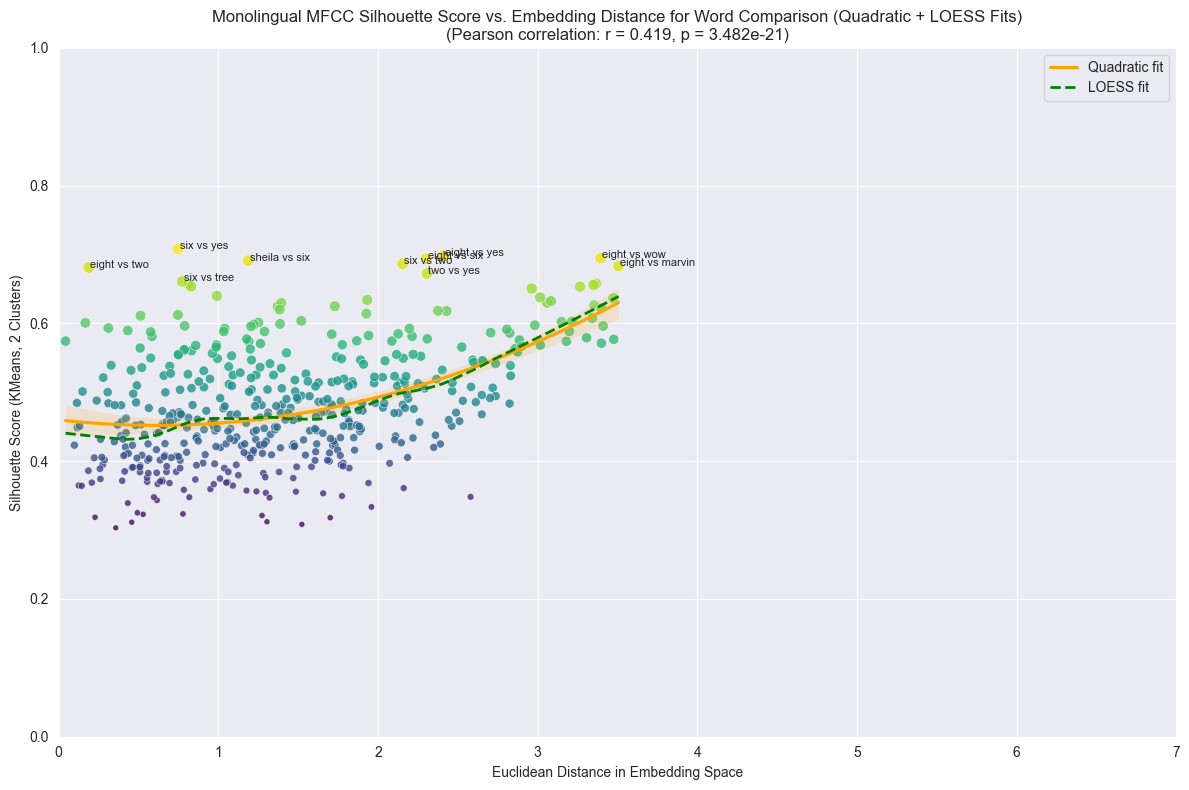

In [11]:
from scipy.stats import pearsonr
import itertools
import statsmodels.api as sm

unique_labels = sorted(set(valid_labels))
label_to_vectors = {label: [] for label in unique_labels}
for label, vec in zip(valid_labels, embedding):
    label_to_vectors[label].append(vec)

# Step 2: Precompute mean embeddings (embedding space) and UMAP means (rotated_df)
label_means_embed = {label: np.mean(vecs, axis=0) for label, vecs in label_to_vectors.items()}
label_means_umap = rotated_df.groupby("keyword")[["x", "y"]].mean().to_dict(orient="index")

# Step 3: Evaluate silhouette and distances
results = []
for kw1, kw2 in itertools.combinations(unique_labels, 2):
    vecs_kw1 = label_to_vectors[kw1]
    vecs_kw2 = label_to_vectors[kw2]
    vectors = np.array(vecs_kw1 + vecs_kw2)
    labels = [kw1] * len(vecs_kw1) + [kw2] * len(vecs_kw2)

    if len(set(labels)) < 2 or len(vectors) < 4:
        continue

    kmeans = KMeans(n_clusters=2, random_state=42)
    cluster_labels = kmeans.fit_predict(vectors)

    try:
        sil_score = silhouette_score(vectors, cluster_labels)
    except ValueError:
        sil_score = np.nan

    # Euclidean distance in full embedding space
    embed_dist = np.linalg.norm(label_means_embed[kw1] - label_means_embed[kw2])

    # Euclidean distance in UMAP space
    if kw1 in label_means_umap and kw2 in label_means_umap:
        umap_vec1 = np.array([label_means_umap[kw1]["x"], label_means_umap[kw1]["y"]])
        umap_vec2 = np.array([label_means_umap[kw2]["x"], label_means_umap[kw2]["y"]])
        umap_dist = np.linalg.norm(umap_vec1 - umap_vec2)
    else:
        umap_dist = np.nan

    results.append({
        'keyword_1': kw1,
        'keyword_2': kw2,
        'silhouette_score': sil_score,
        'embedding_distance': embed_dist,
        'umap_distance': umap_dist
    })

# Step 4: Create DataFrame and clean
results_df = pd.DataFrame(results)
results_df.dropna(inplace=True)

# Step 5: Correlation
r, p = pearsonr(results_df["embedding_distance"], results_df["silhouette_score"])
print(f"Pearson correlation (embedding distance vs silhouette): r = {r:.3f}, p = {p:.3e}")

plt.figure(figsize=(12, 8))

# Scatter plot (unchanged)
sns.scatterplot(
    data=results_df,
    x="embedding_distance",
    y="silhouette_score",
    hue="silhouette_score",
    size="silhouette_score",
    palette="viridis",
    legend=False,
    alpha=0.8
)

# Quadratic fit (unchanged)
sns.regplot(
    data=results_df,
    x="embedding_distance",
    y="silhouette_score",
    scatter=False,
    color="orange",
    order=2,
    ci=95,
    label='Quadratic fit'
)

# --- NEW: Add LOESS trend line ---
# Using statsmodels (more customizable)
lowess = sm.nonparametric.lowess(
    results_df["silhouette_score"],
    results_df["embedding_distance"],
    frac=0.3  # Fraction of data to use for local regression (adjust as needed)
)
plt.plot(
    lowess[:, 0],
    lowess[:, 1],
    color="green",
    linewidth=2,
    linestyle="--",
    label="LOESS fit"
)

plt.xlim(0, 7)      # Force x-axis range (0 to 7)
plt.ylim(0, 1)      # Force y-axis range (0 to 1)

top_n = 10
# Annotate top pairs
for _, row in results_df.nlargest(top_n, "silhouette_score").iterrows():
    plt.text(
        row["embedding_distance"] + 0.01,
        row["silhouette_score"],
        f"{row['keyword_1']} vs {row['keyword_2']}",
        fontsize=8
    )

plt.title(
    f"Monolingual MFCC Silhouette Score vs. Embedding Distance for Word Comparison (Quadratic + LOESS Fits)"
    f"\n(Pearson correlation: r = {r:.3f}, p = {p:.3e})")
plt.xlabel("Euclidean Distance in Embedding Space")
plt.ylabel("Silhouette Score (KMeans, 2 Clusters)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()